In [2]:
datasetName = 'brain_ParietalTemporalFrontalFrontoparietal_Venteicher2017'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_ParietalTemporalFrontalFrontoparietal_Venteicher2017")

In [3]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [4]:
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,cell_ID,MGH42_P7_A01,MGH42_P7_A02,MGH42_P7_A03,MGH42_P7_A04
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,'A1BG',1.28596,0.00000000,0.0000000,0.0000
2,'A1BG-AS1',0.00000,0.00000000,0.0000000,0.0000
3,'A1CF',0.00000,0.06800026,0.0000000,0.0000
4,'A2M',130.95480,194.29348345,0.7060028,194.9851
5,'A2M-AS1',0.00000,0.00000000,0.0000000,0.0000


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<lgl>,<fct>,<fct>,<fct>,<int>
MGH42_P7_A01,brain,left parietal,NA,glioma,Donor 1,female,47
MGH42_P7_A02,brain,left parietal,NA,glioma,Donor 1,female,47
MGH42_P7_A03,brain,left parietal,NA,glioma,Donor 1,female,47
MGH42_P7_A04,brain,left parietal,NA,glioma,Donor 1,female,47
MGH42_P7_A05,brain,left parietal,NA,glioma,Donor 1,female,47


[1] IDH-A IDH-A IDH-A IDH-A IDH-A
Levels: IDH-A

In [5]:
row.names(data.matrix) = data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]

,MGH42_P7_A01,MGH42_P7_A02,MGH42_P7_A03,MGH42_P7_A04,MGH42_P7_A05
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
'A1BG',1.28596,0.00000000,0.0000000,0.0000,0.000000
'A1BG-AS1',0.00000,0.00000000,0.0000000,0.0000,0.000000
'A1CF',0.00000,0.06800026,0.0000000,0.0000,0.000000
'A2M',130.95480,194.29348345,0.7060028,194.9851,0.000000
'A2M-AS1',0.00000,0.00000000,0.0000000,0.0000,3.095104


In [6]:
# Pre-processing
min.cells = 3
min.features = 2500
nFeature_RNA_range = c(2500, 10000)
percent.mt.thre = 5
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


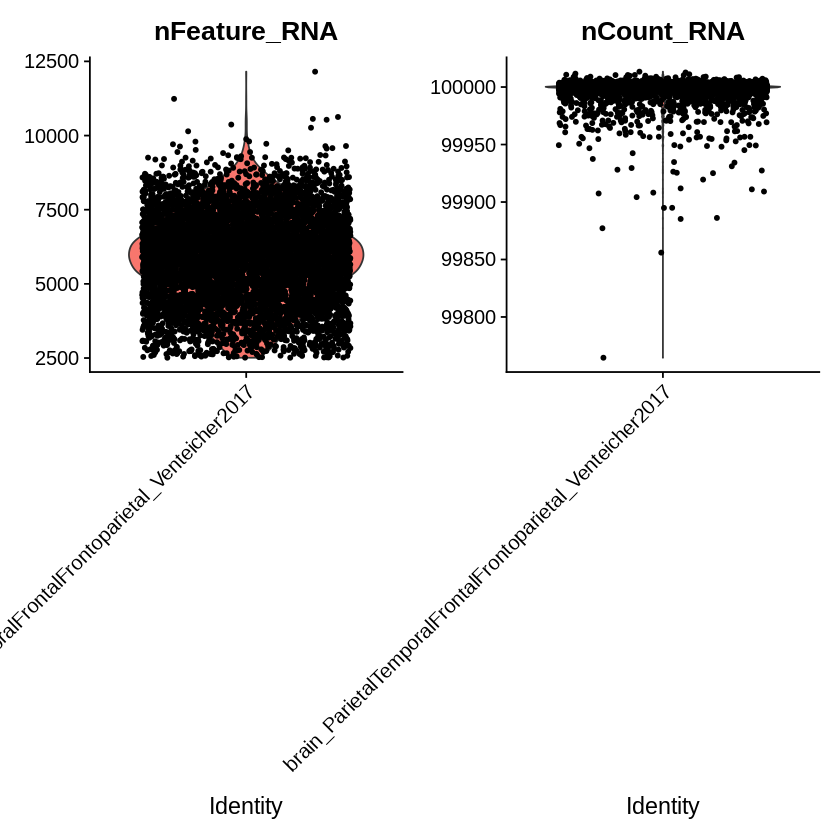

In [7]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA'), ncol = 2)

In [8]:
# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [9]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [10]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  'C1QB', 'LAPTM5', 'C1QC', 'CD74', 'SRGN', 'TYROBP', 'CSF1R', 'C1QA', 'C3', 'RGS1' 
	   'A2M', 'FCER1G', 'HLA-DRA', 'RNASET2', 'SLCO2B1', 'HLA-DPA1', 'HLA-E', 'ITGB2', 'CD53', 'C10orf54' 
	   'CD68', 'CCL3', 'CD83', 'ARHGDIB', 'OLR1', 'ZFP36', 'HLA-DRB1', 'CYBA', 'FCGR2A', 'AIF1' 
Negative:  'PMP2', 'S100B', 'FEZ1', 'APOD', 'DLL3', 'UCHL1', 'BNIP3', 'GFAP', 'TTYH1', 'CLU' 
	   'LINC00689', 'CNP', 'TUBB4A', 'ID1', 'CLDND1', 'SLAIN1', 'NTRK2', 'PSAT1', 'IGFBPL1', 'CPE' 
	   'QDPR', 'ALDOC', 'HEY1', 'SCG2', 'SCD', 'MIR568', 'PLP1', 'KLHL13', 'HIST1H4C', 'SPARCL1' 
PC_ 2 
Positive:  'MAG', 'MOG', 'ERMN', 'ENPP2', 'CLDN11', 'KLK6', 'CNTN2', 'MAL', 'MOBP', 'TMEM144' 
	   'CARNS1', 'PPP1R14A', 'SLC24A2', 'FOLH1', 'TF', 'SEPT4', 'ANLN', 'TMEM125', 'CNDP1', 'GJB1' 
	   'ASPA', 'GPR37', 'MYRF', 'EFHD1', 'CSRP1', 'MYLK', 'CA2', 'PPAP2C', 'RAPGEF5', 'SERPINI1' 
Negative:  'DLL3', 'PMP2', 'LINC00689', 'IGFBPL1', 'IER2', 'BTG2', 'SCG2', 'NPPA', 'GPX1', 'JUN' 
	   'GADD45G', 'KLHL13'

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


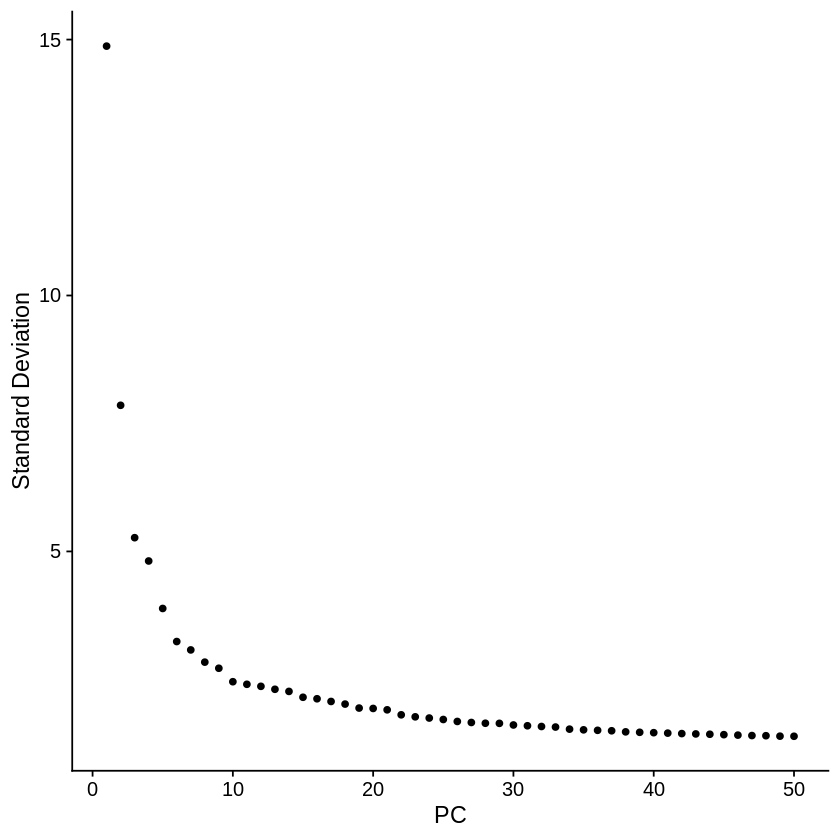

In [11]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [12]:
dev.off()
pcDim = 10 # set as 75 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:08:46 UMAP embedding parameters a = 0.9922 b = 1.112

21:08:46 Read 6333 rows and found 10 numeric columns

21:08:46 Using Annoy for neighbor search, n_neighbors = 30

21:08:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:08:47 Writing NN index file to temp file /tmp/Rtmpkk4zmM/file4cf22e382ddc

21:08:47 Searching Annoy index using 1 thread, search_k = 3000

21:08:49 Annoy recall = 100%

21:08:49 Commencing smooth kNN distance calibration using 1 thread

21:08:49 Initializing fr

In [13]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.5, n.start = 5)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6333
Number of edges: 197684

Running Louvain algorithm...
Maximum modularity in 5 random starts: 0.8653
Number of communities: 12
Elapsed time: 0 seconds


21:09:05 UMAP embedding parameters a = 0.9922 b = 1.112

21:09:05 Read 6333 rows and found 10 numeric columns

21:09:05 Using Annoy for neighbor search, n_neighbors = 30

21:09:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:09:06 Writing NN index file to temp file /tmp/Rtmpkk4zmM/file4cf2524a6a79

21:09:06 Searching Annoy index using 1 thread, search_k = 3000

21:09:08 Annoy recall = 100%

21:09:09 Commencing smooth kNN distance calibration using 1 thread

21:09:09 Initializing from normalized Laplacian + noise

21:09:10 Commencing optimization for 500 epochs, with 255264 positive edges

21:09:24 Optimization finished



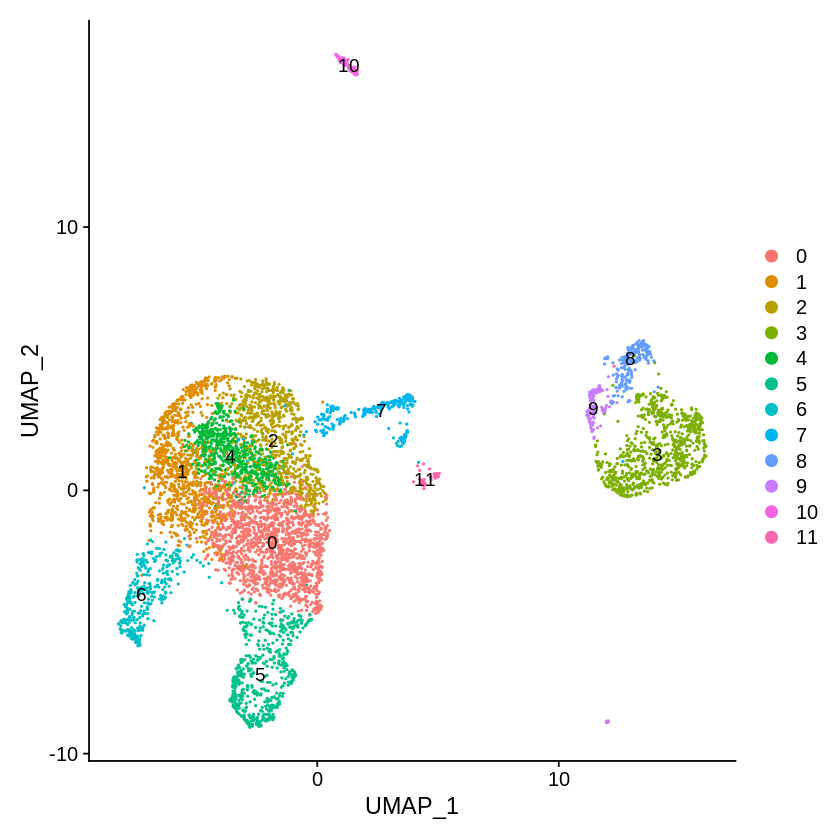

In [14]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [15]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

In [22]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



In [16]:
new.cluster.ids <- c('Brain-Nerve tissue-Inhibitory neuron-GAD1', 'Malignant cell', 'Malignant cell',
                    'Brain-Nerve tissue-Microglia-CX3CR1', 'Brain-Nerve tissue-Inhibitory neuron-GAD1', 'Brain-Nerve tissue-Astrocyte-ALDOC',
                    'Malignant cell', 'Malignant cell', 'Brain-Nerve tissue-Microglia-CX3CR1', 
                    'Brain-Nerve tissue-Microglia-CX3CR1', 'Brain-Nerve tissue-Oligodendrocyte-MBP', 'Brain-Epithelial tissue-Endothelial cell-CLDN5')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

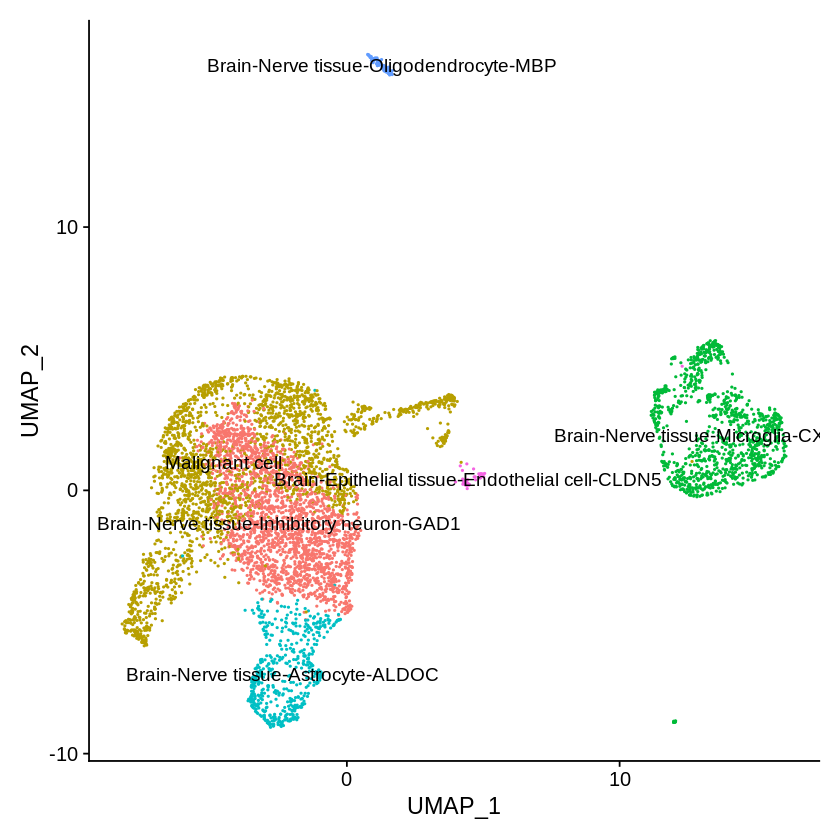

In [17]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [18]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [19]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))